# SIMPLE COW GRAZING SIMULATION USING AGENT-BASED MODELING

In this notebook, I try to simulate a crude adult cow grazing process using agent-based modeling (ABM). Let's proceed to the specifics and the limitations of this analysis.

## Model Details
1. Adult cows (_agents_) are confined in a $n \times n$ square lattice (we call it _field_).
2. $n_{cows}$ are fixed throughout the grazing simulation and are initially placed randomly within the lattice.
3. Each cow possesses a health attribute named $h_{cow} \in [0,1]$.
4. Each patch within the field represents grass and is quantified by its health $h_{grass} \in [0,1]$.
5. Initially, $\rho_{grass, init}$ percent of the field will be filled with grass. $n_{cows}$ will be placed randomly and all will have $h_{cow, init}$.
6. For each time step: <br>
    6.1. One cow (positioned at $x_{cow}, y_{cow}$) will be selected for feeding. <br>
    6.2. It will select among its neighbors for grass where $h_{grass} > 0$ (positioned at $x_{grass}, y_{grass}$) <br>
    6.3. Once the cow chooses a nearest healthy grass patch: <br>
            &nbsp;&nbsp;&nbsp; 6.3.1. The cow will move to that position ($x_{grass}, y_{grass}$) <br>
            &nbsp;&nbsp;&nbsp; 6.3.2. The health of the cow will increase by a factor $g_{cow}$. <br>
            &nbsp;&nbsp;&nbsp; 6.3.3. The health of the grass patch $h_{grass}$ will decrease by a factor $e_{grass}$. <br>
            &nbsp;&nbsp;&nbsp; 6.3.4. In the same manner, $\rho_{grass, grow}$ percent of the field will be selected to grow by a factor $g_{grass}$.

## Model Limitations
1. The unit of time considered in this model is days.
2. From (1), expiration and reproduction of cows were not considered in this model.
3. For each time step, only one cow is assigned to feed on grass. Once done, the cow will be assumed to grow by a factor $g_{cow} > 1$, i.e., $h_{cow, t+1} = h_{cow, t}*g_{cow}$.
4. Grass patches in the field are also assumed to decrease once eaten by the cow, i.e., $h_{grass}$ will decrease by a factor $e_{grass} <1$.
5. The model also assumes that at the end of a time step, some patches of grass will grow by a factor $g_{grass} >1$:  $h_{grass, t+1} = h_{grass, t}*g_{grass}$.

## Agent-based model specifics
For the ABM-based cow grazing, the following parameters were used:
1. Simulation time $t_{ABM} = 300$
2. $n=10$: this means that the field will be simulated in a $10 \times 10$ lattice
3. Number of $n_{cows}=20$; this is fixed throughout the simulation
4. $\rho_{grass, init} = 30 \%$  of the field will be filled with grass
5. Initial health of the cows $h_{cow, init} = 0.1$
6. Growth factor of the cows $g_{cow} = 1.5$
7. Reduction factor of the grass $e_{grass} = 0.9$
8. Growth factor of the cows $g_{grass} = 1.1$
9. $\rho_{grass, grow} = 10 \%$ of the field will be selected to grow by a factor $g_{grass}$.

## Model proper

In [65]:
# Import the libraries
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import random

# Initialize parameters
field_size = (10, 10)
num_cows = 20
initial_grass_coverage = 0.3
grass_growth_factor = 1.1
grass_clip_value = 1
cow_growth_factor = 1.5
initial_cow_growth = 0.1
num_steps = 300
cow_growth_clip_value=1
grass_reduction_factor = 0.9
pct_select_grow_grass = 0.1

# Initialize field with grass
# For reproducibility, we select a random state
np.random.seed(1001)  

field = np.random.choice([0, 1], size=field_size, p=[1-initial_grass_coverage, initial_grass_coverage])


# Initialize cows at random positions
cows = np.random.choice(range(field_size[0]*field_size[1]), size=num_cows, replace=False)
cow_positions = np.array([(pos//field_size[0], pos%field_size[1]) for pos in cows])
cow_growths = np.full(num_cows, initial_cow_growth)

# Define mean cow and grass_health as well as number of fully healthy cow and grass (where health=1) for tracking

avg_h_cows = [np.mean(cow_growths)]
avg_h_grass = [np.mean(field)]
num_fullyh_cows = [(cow_growths == 1.).sum()]
num_fullyh_grass = [(field == 1.).sum()]

##########################################
############## ABM setup #################
##########################################

# Function to update field and cow positions
def update(step):
    global field, cow_positions, cow_growths


    # Function to get neighbors
    def get_neighbors(position):
        neighbors = []
        for dx in [-1, 0, 1]:
            for dy in [-1, 0, 1]:
                if dx == 0 and dy == 0:
                    continue
                new_position = (position[0] + dx, position[1] + dy)
                if 0 <= new_position[0] < field_size[0] and 0 <= new_position[1] < field_size[1]:
                    neighbors.append(new_position)
        return neighbors    
    
    # Feed cows
    cow_to_feed = np.random.randint(num_cows)
    
    neighbors = get_neighbors(cow_positions[cow_to_feed])
    grass_neighbors = [n for n in neighbors if field[n] > 0]
    

    # Move cow to grass and feed
    if grass_neighbors:
        new_position = random.choice(grass_neighbors)
        cow_positions[cow_to_feed] = new_position # move the cow
        cow_growths[cow_to_feed] = min(cow_growths[cow_to_feed] * cow_growth_factor, cow_growth_clip_value)
        field[new_position] *= grass_reduction_factor

        
    # Grow grass
    grow_indices = np.random.choice([0, 1], size=field_size, p=[1-pct_select_grow_grass, pct_select_grow_grass])
    field = np.clip(field + grow_indices * grass_growth_factor, 0, grass_clip_value)
            

    avg_h_cows.append( np.mean(cow_growths) )
    avg_h_grass.append( np.mean(field) )
    num_fullyh_cows.append( (cow_growths == 1.).sum() )
    num_fullyh_grass.append( (field == 1.).sum() )
    
    # print(f'at t={step}')
    # print(cow_growths)
    
    
##########################################
####### Plotting and animation setup #####
##########################################
fig, ax = plt.subplots()


# Create an empty scatter plot to enable the colorbar
scatter1 = ax.scatter([], [], c=[], vmin=0, vmax=1, cmap='copper_r')
scatter2 = ax.scatter([], [], c=[], vmin=0, vmax=1, cmap='Greens')

# Add colorbar to the plot with specified ticks
cbar1 = fig.colorbar(scatter1, ticks=np.arange(0, 1, 0.25), label='Cow Health $h_{cow}$')
cbar2 = fig.colorbar(scatter2,  ticks=np.arange(0, 1, 0.25), label='Grass Health $h_{grass}$')
   

def animate(i):
    ax.clear()
    if i>0:
        update(i)
    grassField = ax.imshow(field, cmap='Greens', vmin=0, vmax=1)
    
    cow_x, cow_y = cow_positions.T

    scatter = ax.scatter(cow_y, cow_x, c=cow_growths, s=70, cmap='copper_r',  marker='o', vmin=0, vmax=1)  # Plot cows
    ax.set_title(f"Step {i}")
    

ani = animation.FuncAnimation(fig, animate, frames=num_steps, repeat=False, interval=10)

plt.close()  # Prevents the final frame plot from showing up inline below the cell


# Save the animation as a .gif file
ani.save('cowGrowth_simul.gif', writer='pillow')

## Post-simulation analysis
I'll do a quick rundown of what happened in the ABM simulation. I will plot the numbers of fully healthy cows ($h_{cow} = 1$) and grass ($h_{grass}$ = 1) through time.

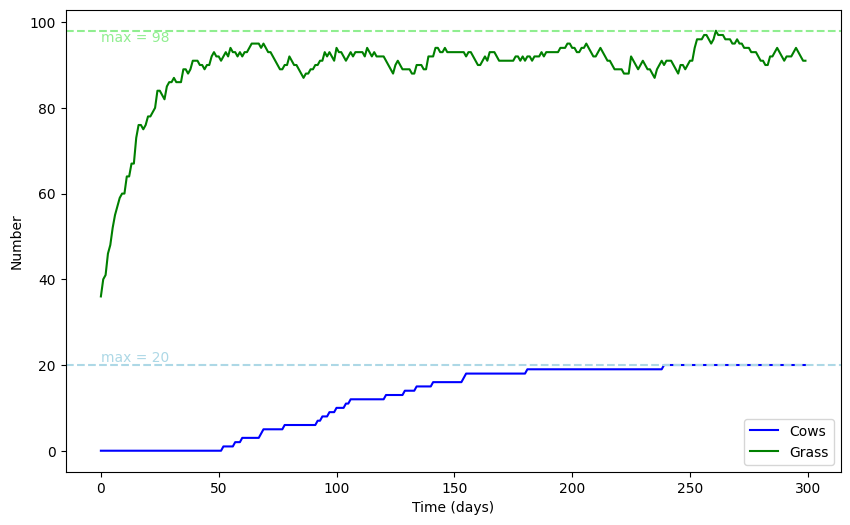

In [50]:
import matplotlib.pyplot as plt

time = range(num_steps)

plt.figure(figsize=(10, 6))

# Plotting the number of fully healthy cows and grass through time
plt.plot(time, num_fullyh_cows, 'b', label='Cows')  # Blue line for cows
plt.plot(time, num_fullyh_grass, 'g', label='Grass')  # Green line for grass

# Add dashed lines for the maximum values
max_cows = max(num_fullyh_cows)
max_grass = max(num_fullyh_grass)
plt.axhline(y=max_cows, color='lightblue', linestyle='--')
plt.axhline(y=max_grass, color='lightgreen', linestyle='--')

# Add text for the maximum values
plt.text(0, max_cows, f"max = {max_cows}", verticalalignment='bottom', color='lightblue')
plt.text(0, max_grass, f"max = {max_grass}", verticalalignment='top', color='lightgreen')

# Add legend, labels + displaying the plot
plt.legend(['Cows', 'Grass'])
plt.xlabel('Time (days)')
plt.ylabel('Number')
plt.show()

In [51]:
## Find the index where the number of fully healthy cows = number of cows in the simulation
index_maxh_cows = num_fullyh_cows.index(20) if 20 in num_fullyh_cows else None

print(index_maxh_cows)

239


The plot above reveals that after $t_{ABM}=300$ days, (1) a field of fully healthy grass ($h_{grass}=1$) was not achieved; (2) all cows in the simulation were fully healthy ($h_{grass}=1$) at $t=239$ d. 

Factors attributing to the failure to achieving a fully healthy grass field may include the fact that after a cow feeds on a grass patch, its health is reduced by a factor $e_{grass}$. Another factor to consider is even if there is a percentage $\rho_{grass, grow} = 10 \%$ selected to grow by a factor $g_{grass}$, it may still not be chosen (from the low percentage) OR the new health of the grass patch may still not reach 1 even if it was chosen. 

Let's try to plot not the numbers, but the percentages of fully healthy cows and grass.

In [53]:
pct_h_cows = [i/num_cows for i in num_fullyh_cows]
pct_h_grass = [i/(field_size[0]*field_size[1]) for i in num_fullyh_grass]

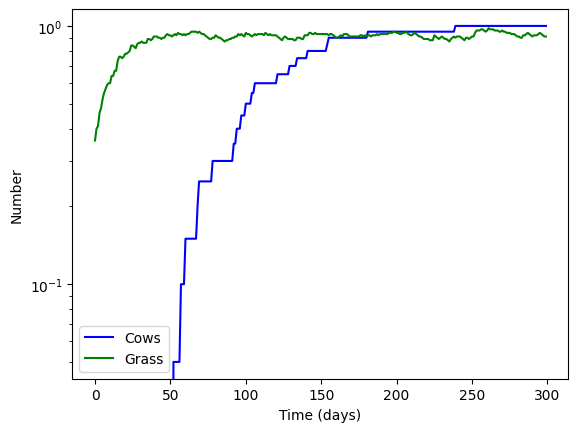

In [62]:
# Plot the percentages
# Use the semilogy scale

time = range(num_steps)

pct_h_cows = [i/num_cows for i in num_fullyh_cows]
pct_h_grass = [i/(field_size[0]*field_size[1]) for i in num_fullyh_grass]

plt.semilogy(time, pct_h_cows, color='blue', label='Cows')
plt.semilogy(time, pct_h_grass, color='green', label='Grass')
plt.ylabel('Number')
plt.xlabel('Time (days)')
plt.legend()
plt.show()

The plot implies that both percentages of fully healthy cows and grass start to trickle around 1 at around $t \sim 150$. 

For the last part, I probe the average health of cows $\langle h_{cow} \rangle$ and grass $\langle h_{grass} \rangle$ through simulation time.

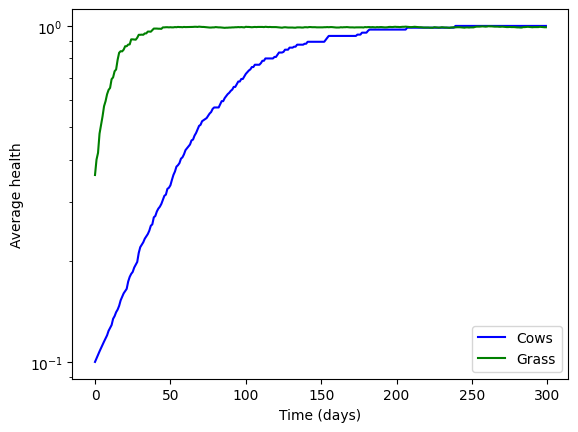

In [63]:
# Plot the average health for cows and grass
# Use the semilogy scale

time = range(num_steps)

plt.semilogy(time, avg_h_cows, color='blue', label='Cows')
plt.semilogy(time, avg_h_grass, color='green', label='Grass')
plt.ylabel('Average health')
plt.xlabel('Time (days)')
plt.legend()
plt.show()

In [60]:
print(max(avg_h_cows), max(avg_h_grass))

1.0 0.998


The plot suggests that $\langle h_{cow} \rangle$ and $\langle h_{grass} \rangle$ trickled around 1 at $t \sim 50$ d and $t \sim 225$ d, respectively. Note that $\langle h_{grass} \rangle$ trickled around 1 way earlier than $\langle h_{cow} \rangle$, but the former never reached an average health of 1. 

In this notebook, I've laid down the foundations of a simple ABM-based cow grazing simulation over a square lattice. Extensions to this project include increasing some growth parameters for cows and grass, introducing distribution-based growth parameters instead of fixed values, and increasing the number of cows initiated to feed. In this notebook, I set one cow to chosen to feed per time step. Not only can this be notebook be applied to cow grazing, this can extend to, say, simulating chicken feeding. This in turn may be applicable to exploring the dynamics of diseases like avian flu. I hope you learned a thing or two from this simple notebook. 🫶🏾